### IMPORTING LIBRARIES

In [1]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark import SparkContext
from operator import add
from pyspark.sql.functions import lit, col, explode, initcap, regexp_replace, split, concat, substring, to_date

### LOADING DATASET

In [2]:
spark = SparkSession.builder.appName('PySparkGooglePlayApps').getOrCreate()

# Enable Arrow-based columnar data transfers
spark.conf.set("spark.sql.execution.arrow.enabled", "true")

googleplaystore_df = spark.read.load('/home/ubuntu/googleplaystore.csv',
                    format='csv',
                    sep = ',',
                    header='true',
                    escape='"',
                    inferSchema='true')

googleplaystore_user_reviews_df = spark.read.load('/home/ubuntu/googleplaystore_user_reviews.csv',
                    format='csv',
                    sep = ',',
                    header='true',
                    escape='"',
                    inferSchema='true')

In [3]:
googleplaystore_df.select("App").where("App like '%\"%'").show(truncate=False)

+------------------------------------------------------+
|App                                                   |
+------------------------------------------------------+
|Eat Fast Prepare "Without Internet"                   |
|Yanosik: "antyradar", traffic jams, navigation, camera|
|Alphabet "H" Passcode Lock Screen                     |
|Official QR Code® Reader "Q"                          |
|Women"s Health Tips(Breast,Face,Body,weight lose)     |
|"i DT" Fútbol. Todos Somos Técnicos.                  |
|The FN "Baby" pistol explained                        |
+------------------------------------------------------+



In [4]:
# Number of rows in the dataframe
googleplaystore_df.show(n=5)

+--------------------+--------------+------+-------+----+-----------+----+-----+--------------+--------------------+----------------+------------------+------------+
|                 App|      Category|Rating|Reviews|Size|   Installs|Type|Price|Content Rating|              Genres|    Last Updated|       Current Ver| Android Ver|
+--------------------+--------------+------+-------+----+-----------+----+-----+--------------+--------------------+----------------+------------------+------------+
|Photo Editor & Ca...|ART_AND_DESIGN|   4.1|    159| 19M|    10,000+|Free|    0|      Everyone|        Art & Design| January 7, 2018|             1.0.0|4.0.3 and up|
| Coloring book moana|ART_AND_DESIGN|   3.9|    967| 14M|   500,000+|Free|    0|      Everyone|Art & Design;Pret...|January 15, 2018|             2.0.0|4.0.3 and up|
|U Launcher Lite –...|ART_AND_DESIGN|   4.7|  87510|8.7M| 5,000,000+|Free|    0|      Everyone|        Art & Design|  August 1, 2018|             1.2.4|4.0.3 and up|
|Ske

In [5]:
# Number of rows in the dataframe
googleplaystore_user_reviews_df.show(n=5)

+--------------------+--------------------+---------+------------------+----------------------+
|                 App|   Translated_Review|Sentiment|Sentiment_Polarity|Sentiment_Subjectivity|
+--------------------+--------------------+---------+------------------+----------------------+
|10 Best Foods for...|I like eat delici...| Positive|               1.0|    0.5333333333333333|
|10 Best Foods for...|This help eating ...| Positive|              0.25|   0.28846153846153844|
|10 Best Foods for...|                 nan|      nan|               nan|                   nan|
|10 Best Foods for...|Works great espec...| Positive|               0.4|                 0.875|
|10 Best Foods for...|        Best idea us| Positive|               1.0|                   0.3|
+--------------------+--------------------+---------+------------------+----------------------+
only showing top 5 rows



### Transformations & Datatype conversions

In [6]:
googleplaystore_df.printSchema()

root
 |-- App: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Rating: double (nullable = true)
 |-- Reviews: string (nullable = true)
 |-- Size: string (nullable = true)
 |-- Installs: string (nullable = true)
 |-- Type: string (nullable = true)
 |-- Price: string (nullable = true)
 |-- Content Rating: string (nullable = true)
 |-- Genres: string (nullable = true)
 |-- Last Updated: string (nullable = true)
 |-- Current Ver: string (nullable = true)
 |-- Android Ver: string (nullable = true)



In [7]:
# Drop unused columns
googleplaystore_df = googleplaystore_df.drop("category", "size", "type", "content rating")

#### Column renaming: Removing spaces.
Rating: Cast to Double.

Installs: Apply regexp to remove unwanted characters and cast to Integer.

Price: Apply regexp to remove unwanted characters and cast to Double.

Last updated: Cast to Date

In [8]:
googleplaystore_df = googleplaystore_df \
    .withColumnRenamed("Android Ver", "android_ver") \
    .withColumnRenamed("Current Ver", "current_ver") \
    .withColumnRenamed("Last Updated", "last_updated") \
    .withColumn("Rating", col("Rating").cast(DoubleType())) \
    .withColumn("Reviews", col("Reviews").cast(IntegerType())) \
    .withColumn("Installs", regexp_replace(col("Installs"), "[^0-9]", "")) \
    .withColumn("Installs", col("Installs").cast(IntegerType())) \
    .withColumn("Price", regexp_replace(col("Price"), "[$]", "")) \
    .withColumn("Price", col("Price").cast(DoubleType())) \
    .withColumn("last_updated", to_date('last_updated', 'MMM d, yyyy'))

In [9]:
# Fill NULL values with 0
googleplaystore_df = googleplaystore_df.fillna(0, "price")

In [10]:
googleplaystore_df.printSchema()

root
 |-- App: string (nullable = true)
 |-- Rating: double (nullable = true)
 |-- Reviews: integer (nullable = true)
 |-- Installs: integer (nullable = true)
 |-- Price: double (nullable = false)
 |-- Genres: string (nullable = true)
 |-- last_updated: date (nullable = true)
 |-- current_ver: string (nullable = true)
 |-- android_ver: string (nullable = true)



### Removing duplicates

In [11]:
#Create temporal view so later we can execute SQL statements
googleplaystore_df.createOrReplaceTempView("apps")

In [12]:
spark.sql("""
SELECT app, rating, reviews, installs, genres, price, android_ver, count(*) rep
FROM apps
GROUP BY app, rating, reviews, installs, genres, price, android_ver
HAVING count(*) > 1
ORDER BY rep DESC
""").show()

+--------------------+------+-------+---------+--------------------+-----+------------------+---+
|                 app|rating|reviews| installs|              genres|price|       android_ver|rep|
+--------------------+------+-------+---------+--------------------+-----+------------------+---+
|                Nick|   4.2| 123279| 10000000|Entertainment;Mus...|  0.0|        4.4 and up|  4|
|          Skyscanner|   4.5| 481546| 10000000|      Travel & Local|  0.0|        4.4 and up|  4|
|           WatchESPN|   4.1| 288809| 10000000|              Sports|  0.0|        4.4 and up|  4|
|eBay: Buy & Sell ...|   4.4|2788923|100000000|            Shopping|  0.0|Varies with device|  4|
|Quizlet: Learn La...|   4.6| 211856| 10000000|           Education|  0.0|Varies with device|  4|
|CBS Sports App - ...|   4.3|  91031|  5000000|              Sports|  0.0|        5.0 and up|  4|
|         Google Keep|   4.4| 691474|100000000|        Productivity|  0.0|Varies with device|  4|
|              O-Sta

In [13]:
# One specific example
spark.sql("""
SELECT  app, rating, reviews, installs, price,
        genres, last_updated, current_ver, android_ver
FROM apps
WHERE app = "Farm Heroes Saga"
""").show(truncate=False)

+----------------+------+-------+---------+-----+------+------------+-----------+-----------+
|app             |rating|reviews|installs |price|genres|last_updated|current_ver|android_ver|
+----------------+------+-------+---------+-----+------+------------+-----------+-----------+
|Farm Heroes Saga|4.4   |7614130|100000000|0.0  |Casual|2018-07-26  |5.1.8      |2.3 and up |
|Farm Heroes Saga|4.4   |7614271|100000000|0.0  |Casual|2018-07-26  |5.1.8      |2.3 and up |
|Farm Heroes Saga|4.4   |7614415|100000000|0.0  |Casual|2018-07-26  |5.1.8      |2.3 and up |
|Farm Heroes Saga|4.4   |7614407|100000000|0.0  |Casual|2018-07-26  |5.1.8      |2.3 and up |
|Farm Heroes Saga|4.4   |7615646|100000000|0.0  |Casual|2018-08-07  |5.2.6      |2.3 and up |
+----------------+------+-------+---------+-----+------+------------+-----------+-----------+



In [14]:
# Remove duplicates
googleplaystore_df = spark.sql("""
WITH app_vw AS
    (SELECT app, rating, reviews, installs, price, genres, last_updated, current_ver, android_ver,
            ROW_NUMBER() OVER (PARTITION BY app ORDER BY current_ver DESC, last_updated DESC, reviews DESC) row_number
    FROM apps)
SELECT app, rating, reviews, installs, price, genres, last_updated, current_ver, android_ver
FROM app_vw
WHERE row_number = 1
""")

In [15]:
googleplaystore_df = googleplaystore_df.dropDuplicates()

In [16]:
# Re-check of duplicates
googleplaystore_df.createOrReplaceTempView("apps")  # Update view

spark.sql("""
SELECT app, rating, reviews, installs, genres, price, android_ver, count(*) rep
FROM apps
GROUP BY app, rating, reviews, installs, genres, price, android_ver
HAVING count(*) > 1
""").show()

+---+------+-------+--------+------+-----+-----------+---+
|app|rating|reviews|installs|genres|price|android_ver|rep|
+---+------+-------+--------+------+-----+-----------+---+
+---+------+-------+--------+------+-----+-----------+---+



In [17]:
#Create temporal view so later we can execute SQL statements
googleplaystore_user_reviews_df.createOrReplaceTempView("reviews")

#### 

### 1. Top 10 applications in regards to the highest number of positive sentiments.

In [18]:
spark.sql("""
SELECT app, count(*) as cnt_pos
FROM reviews
WHERE sentiment = "Positive"
GROUP BY app
ORDER BY cnt_pos DESC
LIMIT 10
""").show(truncate=False)

+------------------------------+-------+
|app                           |cnt_pos|
+------------------------------+-------+
|Helix Jump                    |209    |
|Duolingo: Learn Languages Free|200    |
|Calorie Counter - Macros      |174    |
|Calorie Counter - MyFitnessPal|169    |
|Bowmasters                    |169    |
|10 Best Foods for You         |162    |
|Google Photos                 |143    |
|8fit Workouts & Meal Planner  |137    |
|Garena Free Fire              |136    |
|DRAGON BALL LEGENDS           |127    |
+------------------------------+-------+



### 2. Histogram for the number of installations.

In [19]:
histogram = spark.sql("""
SELECT  NVL(installs, 0) installs
        , count(*) frequency
FROM apps
GROUP BY NVL(installs, 0)
ORDER BY 1
""")

In [20]:
# Programmatic way to replace NULL with 0
histogram = histogram.fillna(0, "installs")

In [21]:
histogram.where("installs is null").show()

+--------+---------+
|installs|frequency|
+--------+---------+
+--------+---------+



In [22]:
histogram.show()

+----------+---------+
|  installs|frequency|
+----------+---------+
|         0|       16|
|         1|       67|
|         5|       82|
|        10|      385|
|        50|      204|
|       100|      710|
|       500|      328|
|      1000|      887|
|      5000|      468|
|     10000|     1031|
|     50000|      469|
|    100000|     1111|
|    500000|      505|
|   1000000|     1419|
|   5000000|      606|
|  10000000|      935|
|  50000000|      204|
| 100000000|      189|
| 500000000|       24|
|1000000000|       20|
+----------+---------+



In [23]:
# Conversion: Spark DF to Pandas DF
plotdf = histogram.toPandas()

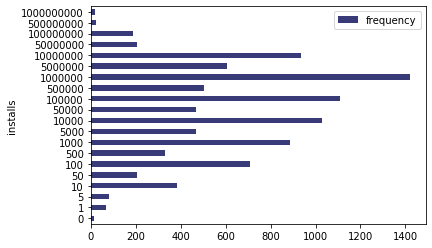

In [32]:
# Pandas internal plot library
plotdf.plot(kind='barh', x='installs', y='frequency', colormap='tab20b')

### 3. Applications with more positive sentiments than negative and neutral together and having a rating of at least 4.2

In [24]:
spark.sql("""
SELECT  app, 
        SUM(CASE sentiment WHEN "Positive" THEN 1 ELSE 0 END) positive, 
        SUM(CASE sentiment WHEN "Negative" THEN 1 ELSE 0 END) negative, 
        SUM(CASE sentiment WHEN "Neutral" THEN 1 ELSE 0 END) neutral
FROM reviews r
WHERE r.sentiment != "nan"
GROUP BY app
""").show(truncate=False)

+-------------------------------------+--------+--------+-------+
|app                                  |positive|negative|neutral|
+-------------------------------------+--------+--------+-------+
|BaBe+ - Berita Indonesia             |13      |2       |5      |
|Basketball Stars                     |44      |41      |4      |
|Davis's Drug Guide for Nurses        |2       |0       |1      |
|Find&Save - Local Shopping           |20      |7       |4      |
|Bloomberg Professional               |15      |11      |14     |
|Floor Plan Creator                   |26      |3       |8      |
|Happy Fruits Bomb - Cube Blast       |13      |7       |5      |
|Bagan - Myanmar Keyboard             |21      |2       |9      |
|Candy Pop Story                      |22      |13      |5      |
|Cricbuzz - Live Cricket Scores & News|26      |11      |1      |
|Google Earth                         |23      |10      |5      |
|Homework Planner                     |33      |4       |0      |
|AOL - New

### Trying to find correlation between some of the attributes

#### 1. Correlation between sentiment and rating

In [25]:
spark.sql("""
WITH reviews_vw AS
    (SELECT app, 
            SUM(CASE sentiment WHEN "Positive" THEN 1 ELSE 0 END) positive, 
            SUM(CASE sentiment WHEN "Negative" THEN 1 ELSE 0 END) negative, 
            SUM(CASE sentiment WHEN "Neutral" THEN 1 ELSE 0 END) neutral
    FROM reviews r
    WHERE r.sentiment != "nan"
    GROUP BY app
    )
SELECT a.app, a.rating, positive, negative, neutral
FROM apps a, reviews_vw r
WHERE a.app = r.app
AND a.rating >= 4.2
AND positive > neutral + negative
""").show(30, truncate=False)

+--------------------------------------------------+------+--------+--------+-------+
|app                                               |rating|positive|negative|neutral|
+--------------------------------------------------+------+--------+--------+-------+
|Davis's Drug Guide for Nurses                     |4.5   |2       |0       |1      |
|Happy Fruits Bomb - Cube Blast                    |4.5   |13      |7       |5      |
|Candy Pop Story                                   |4.7   |22      |13      |5      |
|Cricbuzz - Live Cricket Scores & News             |4.5   |26      |11      |1      |
|Google Earth                                      |4.3   |23      |10      |5      |
|Epocrates Plus                                    |4.3   |29      |6       |5      |
|Arrow.io                                          |4.5   |53      |28      |14     |
|CALCU™ Stylish Calculator Free                    |4.7   |27      |1       |10     |
|FilterGrid - Cam&Photo Editor                     |4.

In [26]:
spark.sql("""
WITH apps_vw AS
    (SELECT app, rating, reviews, installs, price, genres
    FROM apps
    ),
reviews_vw AS
    (SELECT app, 
            SUM(CASE sentiment WHEN "Positive" THEN 1 ELSE 0 END) positive, 
            SUM(CASE sentiment WHEN "Negative" THEN 1 ELSE 0 END) negative, 
            SUM(CASE sentiment WHEN "Neutral" THEN 1 ELSE 0 END) neutral
    FROM reviews r
    WHERE r.sentiment != "nan"
    GROUP BY app
    )
SELECT a.app, price, rating, installs, reviews, positive, negative, neutral
FROM apps_vw a, reviews_vw r
WHERE a.app = r.app
AND positive > negative + neutral
ORDER BY positive DESC
""").show()

+--------------------+-----+------+----------+--------+--------+--------+-------+
|                 app|price|rating|  installs| reviews|positive|negative|neutral|
+--------------------+-----+------+----------+--------+--------+--------+-------+
|          Helix Jump|  0.0|   4.2| 100000000| 1500999|     209|      58|      6|
|Duolingo: Learn L...|  0.0|   4.7| 100000000| 6297590|     200|      34|      6|
|Calorie Counter -...|  0.0|   4.0|    100000|    3061|     174|      20|      6|
|Calorie Counter -...|  0.0|   4.6|  50000000| 1873523|     169|      52|     34|
|          Bowmasters|  0.0|   4.7|  50000000| 1536349|     169|     119|     24|
|10 Best Foods for...|  0.0|   4.0|    500000|    2490|     162|      10|     22|
|       Google Photos|  0.0|   4.5|1000000000|10859051|     143|      47|      1|
|8fit Workouts & M...|  0.0|   4.6|  10000000|  115721|     137|      19|     15|
|    Garena Free Fire|  0.0|   4.5| 100000000| 5534114|     136|      81|      5|
| DRAGON BALL LE

In [27]:
spark.sql("""
WITH apps_vw AS
    (SELECT app, rating, reviews, installs, price, genres
    FROM apps
    ),
reviews_vw AS
    (SELECT app,
            SUM(CASE sentiment WHEN "Positive" THEN 1 ELSE 0 END) positive, 
            SUM(CASE sentiment WHEN "Negative" THEN 1 ELSE 0 END) negative, 
            SUM(CASE sentiment WHEN "Neutral" THEN 1 ELSE 0 END) neutral
    FROM reviews r
    WHERE r.sentiment != "nan"
    GROUP BY app
    )
SELECT a.app, price, rating, installs, reviews, negative, positive, neutral
FROM apps_vw a, reviews_vw r
WHERE a.app = r.app
AND negative > positive + neutral
ORDER BY negative DESC
""").show()

+--------------------+-----+------+----------+--------+--------+--------+-------+
|                 app|price|rating|  installs| reviews|negative|positive|neutral|
+--------------------+-----+------+----------+--------+--------+--------+-------+
| Angry Birds Classic|  0.0|   4.4| 100000000| 5566908|     147|     124|      2|
|    Candy Crush Saga|  0.0|   4.4| 500000000|22430188|     126|     102|     12|
|Candy Crush Soda ...|  0.0|   4.4| 100000000| 6199095|      96|      62|      8|
|       Cooking Fever|  0.0|   4.5| 100000000| 3198176|      79|      55|      1|
| Be A Legend: Soccer|  0.0|   3.8|   1000000|   85763|      59|      33|      6|
|Candy Crush Jelly...|  0.0|   4.3|  50000000| 1300619|      44|      21|      8|
|     Angry Birds Rio|  0.0|   4.4| 100000000| 2610680|      23|      15|      1|
|       Guns of Glory|  0.0|   4.0|  10000000|  120592|      23|      14|      3|
|GoPro (formerly C...|  0.0|   4.0|  10000000|  157506|      23|      15|      1|
|          Color

#### 2. Correlation between price and number of installations

In [28]:
spark.sql("""
SELECT app, price, rating, installs, genres, reviews
FROM apps
ORDER BY price DESC, installs
""").show(30, truncate=False)

+-------------------------------------+------+------+--------+-------------+-------+
|app                                  |price |rating|installs|genres       |reviews|
+-------------------------------------+------+------+--------+-------------+-------+
|I'm Rich - Trump Edition             |400.0 |3.6   |10000   |Lifestyle    |275    |
|I'm Rich/Eu sou Rico/أنا غني/我很有錢|399.99|NaN   |0       |Lifestyle    |0      |
|most expensive app (H)               |399.99|4.3   |100     |Entertainment|6      |
|I am Rich!                           |399.99|3.8   |1000    |Finance      |93     |
|I AM RICH PRO PLUS                   |399.99|4.0   |1000    |Finance      |36     |
|I am rich (Most expensive app)       |399.99|4.1   |1000    |Finance      |129    |
|I Am Rich Pro                        |399.99|4.4   |5000    |Entertainment|201    |
|I am Rich                            |399.99|4.3   |5000    |Finance      |180    |
|I am rich(premium)                   |399.99|3.5   |5000    |Finance

In [29]:
# The cheaper the app is, the more times it gets installed
spark.sql("""
SELECT    CASE WHEN price = 0 THEN 1 ELSE 0 END Free
        , CASE WHEN price > 0 AND price <= 10 THEN 1 ELSE 0 END `0.1to10`
        , CASE WHEN price > 10 AND price <= 20 THEN 1 ELSE 0 END `10to20`
        , CASE WHEN price > 20 AND price <= 50 THEN 1 ELSE 0 END `20to50`
        , CASE WHEN price > 50 AND price <= 100 THEN 1 ELSE 0 END `50to100`
        , CASE WHEN price > 100 AND price <= 200 THEN 1 ELSE 0 END `100to200`
        , CASE WHEN price > 200 AND price <= 300 THEN 1 ELSE 0 END `200to300`
        , CASE WHEN price > 300 AND price <= 400 THEN 1 ELSE 0 END `300to400`
        , SUM(installs) total_installs
FROM apps
GROUP BY 1, 2, 3, 4, 5, 6, 7, 8
ORDER BY 9 DESC
""").show()

+----+-------+------+------+-------+--------+--------+--------+--------------+
|Free|0.1to10|10to20|20to50|50to100|100to200|200to300|300to400|total_installs|
+----+-------+------+------+-------+--------+--------+--------+--------------+
|   1|      0|     0|     0|      0|       0|       0|       0|   75242472646|
|   0|      1|     0|     0|      0|       0|       0|       0|      56487944|
|   0|      0|     1|     0|      0|       0|       0|       0|        490580|
|   0|      0|     0|     0|      0|       0|       0|       1|        209100|
|   0|      0|     0|     1|      0|       0|       0|       0|        164246|
|   0|      0|     0|     0|      0|       0|       1|       0|         10000|
|   0|      0|     0|     0|      1|       0|       0|       0|          2010|
|   0|      0|     0|     0|      0|       1|       0|       0|             1|
+----+-------+------+------+-------+--------+--------+--------+--------------+



In [30]:
spark.sql("""
WITH app_vw AS
        (select   CASE WHEN price = 0 THEN 1 ELSE 0 END Free
                , CASE WHEN price > 0 AND price <= 10 THEN 1 ELSE 0 END `0.1to10`
                , CASE WHEN price > 10 AND price <= 20 THEN 1 ELSE 0 END `10to20`
                , CASE WHEN price > 20 AND price <= 50 THEN 1 ELSE 0 END `20to50`
                , CASE WHEN price > 50 AND price <= 100 THEN 1 ELSE 0 END `50to100`
                , CASE WHEN price > 100 AND price <= 200 THEN 1 ELSE 0 END `100to200`
                , CASE WHEN price > 200 AND price <= 300 THEN 1 ELSE 0 END `200to300`
                , CASE WHEN price > 300 AND price <= 400 THEN 1 ELSE 0 END `300to400`
                , SUM(installs) total_installs
        from apps
        GROUP BY 1, 2, 3, 4, 5, 6, 7, 8)
SELECT *,
       ROUND(total_installs / SUM(total_installs) OVER () * 100, 2) percent
FROM app_vw
ORDER BY 9 DESC
""").show()

+----+-------+------+------+-------+--------+--------+--------+--------------+-------+
|Free|0.1to10|10to20|20to50|50to100|100to200|200to300|300to400|total_installs|percent|
+----+-------+------+------+-------+--------+--------+--------+--------------+-------+
|   1|      0|     0|     0|      0|       0|       0|       0|   75242472646|  99.92|
|   0|      1|     0|     0|      0|       0|       0|       0|      56487944|   0.08|
|   0|      0|     1|     0|      0|       0|       0|       0|        490580|    0.0|
|   0|      0|     0|     0|      0|       0|       0|       1|        209100|    0.0|
|   0|      0|     0|     1|      0|       0|       0|       0|        164246|    0.0|
|   0|      0|     0|     0|      0|       0|       1|       0|         10000|    0.0|
|   0|      0|     0|     0|      1|       0|       0|       0|          2010|    0.0|
|   0|      0|     0|     0|      0|       1|       0|       0|             1|    0.0|
+----+-------+------+------+-------+-------

#### 3. Correlation between rating and number of installations

In [31]:
# Higher rated apps are more frequently installed. 
spark.sql("""
SELECT CASE WHEN rating <= 2 THEN 1 ELSE 0 END `0-2`
        , CASE WHEN rating > 2 AND rating <= 3 THEN 1 ELSE 0 END `2-3`
        , CASE WHEN rating > 3 AND rating <= 4 THEN 1 ELSE 0 END `3-4`
        , CASE WHEN rating > 4 AND rating <= 5 THEN 1 ELSE 0 END `4-5`
        , SUM(installs)
FROM apps
GROUP BY 1, 2, 3, 4
ORDER BY 5 DESC
""").show()

+---+---+---+---+-------------+
|0-2|2-3|3-4|4-5|sum(installs)|
+---+---+---+---+-------------+
|  0|  0|  0|  1|  65432846753|
|  0|  0|  1|  0|   9800476630|
|  0|  1|  0|  0|     54654330|
|  1|  0|  0|  0|      5996625|
|  0|  0|  0|  0|      5862189|
+---+---+---+---+-------------+

